In [270]:
# numeric stack
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt

# additional modules
import glob
import re

# Handling Jmeter Test Results
Written by Andrew Kapuscinski

## There are two types of files we get from running a Jmeter test:
1. *filename_results*.jtl files
2. *filename_log*.txt files

### These type of files each have useful data the we can use to create a report for the client

The **.jtl** files are formatted like:

<font color="blue">*timeStamp,elapsed,label,responseCode,responseMessage,threadName,dataType,success,failureMessage,bytes,sentBytes,grpThreads,allThreads,Latency,IdleTime,Connect
2017/07/18 18:25:53.101,704,UC-GGR-P3-DM01 - /login.do,200,OK,UC-GGR-P3-DM01 1-3,text,true,,13384,200,4,13,704,0,625*</font>

And,
the **log.txt** files are formatted like:

<font color="blue">*2017/07/18 18:47:00 INFO  - jmeter.reporters.Summariser: summary +    126 in 00:00:30 =    4.2/s Avg:  1187 Min:   161 Max: 40232 Err:    12 (9.52%) Active: 200 Started: 366 Finished: 166 
<br>
2017/07/18 18:47:00 INFO  - jmeter.reporters.Summariser: summary =  21154 in 00:41:31 =    8.5/s Avg:  1145 Min:     0 Max: 132107 Err:   327 (1.55%)*</font>

## Here we go!
Set paths to each group of files

In [2]:
loglist = glob.glob("../realcsv/logs/" + "*.txt")
resultlist = glob.glob("../realcsv/" + "*.jtl")

Check if the number of files for each group is correct

In [3]:
logcount = len(loglist)
rescount = len(resultlist)
print("Number of log files:", logcount)
print("Number of result files:", rescount)

Number of log files: 50
Number of result files: 50


## First, we'll deal with the log files

In [4]:
# empty list
lframes = [] # log frames list
lrawframes = [] # log raw data list
threadframe = [] # thread count list

dframeLogs = pd.DataFrame()
dframeLogsRaw = pd.DataFrame()
dframeLogthread = pd.DataFrame()

# names to use for column header
colnames=['date', 'time', '2', '3', '4', '5', '6', 'numofthreads', '8', 'elapsed', '10', '11', '12', 'avg', '14', 'min', '16', 'max', '18', 'err', '20']

for log in loglist:
    ldf = pd.read_csv(log, delimiter="\n", index_col=None, header=None)
    lrawdf, threadf = ldf, ldf
    
    threadf = threadf[(threadf[0].str.contains("Thread finished"))] # contains Thread finished
    lrawdf = lrawdf[(lrawdf[0].str.contains("jmeter.reporters.Summariser:\s+summary\s+\+"))] # contains +
    ldf = ldf[(ldf[0].str.contains("- jmeter.reporters.Summariser: summary ="))] # contains =    
    
    threadf = threadf[0].str[1:-1].str.split(expand=True)
    lrawdf = lrawdf[0].str[1:-1].str.split(expand=True) # split single column to multiple columns
    ldf= ldf[0].str[1:-1].str.split(expand=True) # split single column to multiple columns

    ldf.columns = colnames # rename column names , lrawdf.columns
    ldf = ldf.tail(1) # only use the last line of the DataFrame
    
    lframes.append(ldf) # add each DataFrame to it's respective list
    lrawframes.append(lrawdf)
    threadframe.append(threadf)

    
dframeLogs = pd.concat(lframes) # concat the 'lframes' list to the 'dframe' DataFrame Object
dframeLogsRaw = pd.concat(lrawframes) # concat the 'lrawframes' list to the 'dframe' DataFrame Object
dframeLogthread = pd.concat(threadframe) # concat the 'threadframe' list to the 'dframe' DataFrame Object

# make these columns numeric
dframeLogs[['numofthreads','avg','min','max','err']] = dframeLogs[['numofthreads','avg','min','max','err']].apply(pd.to_numeric)


#### Print results!

In [6]:
# total number errors = sum of errors
print("Total number of HTTP Request/Response failures across all servers is:", dframeLogs.err.sum())

# HTTP Failure rate = (total error / total threads)*100
print("HTTP Request/Reponse Failure Rate is: {0:.2f}%".format(((dframeLogs.err.sum() / dframeLogs.numofthreads.sum()) * 100)))

Total number of HTTP Request/Response failures across all servers is: 18552
HTTP Request/Reponse Failure Rate is: 1.83%


## Next, we'll go through the .jtl result files

We'll want to separate the Transaction Controllers and the Errors from the results file.
<br>
I set up two lists to put the filtered data in:
1. **'rframes'** for Transaction Controllers
2. **'errframes'** for errors

In [271]:
# create empty lists for results and errors
rframes = []
errframes = []

# resultslist was declared when we read the jtl files from our directory 
for res in resultlist:
    rdf = pd.read_csv(res, index_col=None, header=0)
    errdf = rdf
    
    errdf = rdf[(rdf.responseCode != "200") & (~rdf.responseCode.isnull())] # find failed 
    rdf = rdf[(rdf.label.str.contains("Transaction"))] # find transaction controllers
    
#     split 'label' column into three parts
    rdf['UC'], rdf['T'], rdf['C'] = zip(*rdf['label'].apply(lambda x: x.split()))
    
#     split 'responseMessage' column into five parts
    rdf['resmsg1'], rdf['numSampleInTrans'], rdf['resmsg2'], rdf['numFailSamples'], rdf['resmsg3'] = zip(*rdf['responseMessage'].apply(lambda y: re.split("([\d]+)", y)))
    
#     append to respective list
    rframes.append(rdf)
    errframes.append(errdf)
    

### Now we have two lists...
We'll create two DataFrame objects one for 'rframes' and one for 'errframes'.
<br>
Then, we'll concat the lists we create above to them, respectively.

In [8]:
dframeRes = pd.DataFrame()
dframeErr = pd.DataFrame()

dframeErr = pd.concat(errframes)
dframeRes = pd.concat(rframes)

The columns in the DataFrames are strings.
<br>
Let's turn the columns listed below into numbers with to_numeric()

In [9]:
dframeRes[['elapsed','bytes','numSampleInTrans','numFailSamples','Latency','sentBytes']] = dframeRes[['elapsed','bytes','numSampleInTrans','numFailSamples','Latency','sentBytes']].apply(pd.to_numeric)

In [274]:
# uncomment lines below to show our base DataFrame
# dframeRes
# dframeErr

### Let's figure out the Success and Error rates
First, we need to group the rows by the UC column.
<br>
Then, we need to get a list of all the unique 'names' from the UC column with unique()

In [ ]:
grouped = dframeRes.groupby(["UC"])
allUCs = dframeRes.UC.unique()

# uncomment to show all unique UCs
# print(allUCs)

successRate = pd.DataFrame()
totalTCs = []

for uc in allUCs:
    ucdf = grouped.get_group(uc)
#     find all 'actual' data, meaning only count 1's or 0's from Failing samples column
    actual = ucdf.numFailSamples <= 1
    ucdf = ucdf[actual]
    fails = len(ucdf[(ucdf.numFailSamples == 1)]) # get fails
    attempted = len(ucdf[(ucdf.numFailSamples <= 1)]) # get attempted
    successes = attempted - fails # calculate successes
#     create dataframe with calculated data
    calcdf = pd.DataFrame({"Test Case": [uc],"Fails": fails, "Successes": successes,"Attempted": attempted})
    totalTCs.append(calcdf) # append dataframes to totalTCs list
    
successRate = pd.concat(totalTCs) # append to successRate DataFrame

#### Print results

In [11]:
print("Total Number of Test-Case Results:", successRate.Attempted.sum())
print("Test-Case Success Rate is: {0:.2f}%".format((successRate.Successes.sum() / successRate.Attempted.sum() * 100)))
print("Test-Case Failure Rate is: {0:.2f}%".format((successRate.Fails.sum() / successRate.Attempted.sum() * 100)))

successRate[['Test Case','Successes','Attempted']].reset_index()

Total Number of Test-Case Results: 41059
Test-Case Success Rate is: 54.92%
Test-Case Failure Rate is: 45.08%


,index,Test Case,Successes,Attempted
0,0,UC-ASP-MathAUTO,477,720
1,0,UC-ASP-P1-CBMReading,8929,12000
2,0,UC-SPEREM-CU-EarlyMath,2137,3960
3,0,UC-SPEREM-CU02-EarlyRead,4587,7920
4,0,UC-ASP-P1-aReading,1901,7200
5,0,UC-ASP-P1-aMath,3078,6800
6,0,UC-ASP-P1-CBMMathProcess,647,840
7,0,UC-ASP-P1-CBMMathCap,178,560
8,0,UC-IB-P2-SP01,68,120
9,0,UC-CCR-P1-SP01,5,10


# Now, we'll handle the different types of errors
Jmeter results report different types of HTTP errors, such as 404, 503, and Gateway Timeouts.
<br>
It also logs URI Syntax Exceptions that are helpful to troubleshoot what went wrong with certain parts of a test.

In [12]:
dframeErr['timeStamp'] = pd.to_datetime(dframeErr.timeStamp)
dframeErr.set_index('timeStamp', inplace=True)

### Errors during testing period based on timeStamp
Here we'll show the type and amount of errors at any given time in a test.
<br>
We'll start by grouping the data in 1/2 minute segments
<br>
Then we'll create a new Dataframe that shows all the types of errors that occurred and how many there were.

In [277]:
errgrp = dframeErr.groupby(pd.TimeGrouper('.5min'))

# get list of response codes
typeoferrs = errgrp.responseCode

errorsPeriod = pd.DataFrame({"Response Code": typeoferrs.unique(), "# Of Errors": errgrp.responseCode.count()}).reset_index()

# only show rows with errors
errorsPeriod[(errorsPeriod["# Of Errors"] > 0)]

,timeStamp,# Of Errors,Response Code
0,2017-07-18 18:11:00,4,[Non HTTP response code: java.net.URISyntaxExc...
1,2017-07-18 18:11:30,2,[Non HTTP response code: java.net.URISyntaxExc...
2,2017-07-18 18:12:00,1,[Non HTTP response code: java.net.URISyntaxExc...
3,2017-07-18 18:12:30,2,[Non HTTP response code: java.net.URISyntaxExc...
4,2017-07-18 18:13:00,2,[Non HTTP response code: java.net.URISyntaxExc...
5,2017-07-18 18:13:30,2,[Non HTTP response code: java.net.URISyntaxExc...
6,2017-07-18 18:14:00,5,[Non HTTP response code: java.net.URISyntaxExc...
7,2017-07-18 18:14:30,2,[Non HTTP response code: java.net.URISyntaxExc...
8,2017-07-18 18:15:00,3,[Non HTTP response code: java.net.URISyntaxExc...
9,2017-07-18 18:15:30,3,[Non HTTP response code: java.net.URISyntaxExc...


### Errors Total based on error type
Here we'll group the data by the 'responseMessage' and 'responseCode' columns.
<br>
Then, we count them.

In [14]:
numgrp = dframeErr.groupby('responseMessage')['responseCode']

numErrors = pd.DataFrame({"count": numgrp.count()})

numErrors


,count
responseMessage,
GATEWAY_TIMEOUT,3888
Internal Server Error,5330
Non HTTP response message: Illegal character in query at index 58: https://pvs-app02.fastbridge.org/createSession.do?userId=${sess_g1}&sessionCreds=${sess_g2}&db=${sess_g3},114
Non HTTP response message: Illegal character in query at index 64: https://pvs-app02.fastbridge.org/screeninglist/single.do?grpId=${aReading2_g1}&amId=${aReading2_g2},7
Non HTTP response message: Illegal character in query at index 64: https://pvs-app02.fastbridge.org/screeninglist/single.do?grpId=${aReading_g1}&amId=${aReading_g2},4
Non HTTP response message: Illegal character in query at index 65: https://pvs-app02.fastbridge.org/scoring/administerCBMR.do?mode=${cbmre2_g1}&stMode=${cbmre2_g2}&amId=1&spId=3148988&grpSchId=${cbmre2_g5}&grpId=3831062&grpType=${cbmre2_g7}&psgSet=${cbmre2_g8}&occ=${cbmre2_g9}&num=3&spfn=KID006083+KID006083,1
Non HTTP response message: Illegal character in query at index 71: https://pvs-app02.fastbridge.org/scoring/composite.do?cParam=cAdmin$m*${dc1_g1}$sm*${dc1_g2}$a*${dc1_g3}$sp*3162709$gs*${dc1_g5}$gi*${dc1_g6}$gt*${dc1_g7}$pg*Scr-DCI-Gx$o*${dc1_g8}$n*${dc1_g9}$sf*KID019804+KID019804$cAdmin$m*${sp_g1}$sm*${sp_g2}$a*${sp_g3}$sp*3162709$gs*${sp_g5}$gi*${sp_g6}$gt*${sp_g7}$pg*Scr-SP-Gx$o*${sp_g8}$n*${sp_g9}$sf*KID019804+KID019804$cAdmin$m*${pv_g1}$sm*${pv_g2}$a*${pv_g3}$sp*3162709$gs*${pv_g5}$gi*${pv_g6}$gt*${pv_g7}$pg*Scr-PV-Gx$o*${pv_g8}$n*${pv_g9}$sf*KID019804+KID019804,1
Non HTTP response message: Illegal character in query at index 71: https://pvs-app02.fastbridge.org/scoring/composite.do?cParam=cAdmin$m*${dc1_g1}$sm*${dc1_g2}$a*${dc1_g3}$sp*3162713$gs*${dc1_g5}$gi*${dc1_g6}$gt*${dc1_g7}$pg*Scr-DCI-Gx$o*${dc1_g8}$n*${dc1_g9}$sf*KID019808+KID019808$cAdmin$m*${sp_g1}$sm*${sp_g2}$a*${sp_g3}$sp*3162713$gs*${sp_g5}$gi*${sp_g6}$gt*${sp_g7}$pg*Scr-SP-Gx$o*${sp_g8}$n*${sp_g9}$sf*KID019808+KID019808$cAdmin$m*${pv_g1}$sm*${pv_g2}$a*${pv_g3}$sp*3162713$gs*${pv_g5}$gi*${pv_g6}$gt*${pv_g7}$pg*Scr-PV-Gx$o*${pv_g8}$n*${pv_g9}$sf*KID019808+KID019808,1
Non HTTP response message: Illegal character in query at index 71: https://pvs-app02.fastbridge.org/scoring/composite.do?cParam=cAdmin$m*${dc1_g1}$sm*${dc1_g2}$a*${dc1_g3}$sp*3162730$gs*${dc1_g5}$gi*${dc1_g6}$gt*${dc1_g7}$pg*Scr-DCI-Gx$o*${dc1_g8}$n*${dc1_g9}$sf*KID019825+KID019825$cAdmin$m*${sp_g1}$sm*${sp_g2}$a*${sp_g3}$sp*3162730$gs*${sp_g5}$gi*${sp_g6}$gt*${sp_g7}$pg*Scr-SP-Gx$o*${sp_g8}$n*${sp_g9}$sf*KID019825+KID019825$cAdmin$m*${pv_g1}$sm*${pv_g2}$a*${pv_g3}$sp*3162730$gs*${pv_g5}$gi*${pv_g6}$gt*${pv_g7}$pg*Scr-PV-Gx$o*${pv_g8}$n*${pv_g9}$sf*KID019825+KID019825,1


### Errors by testcase


In [15]:
testgrp = dframeErr.groupby(['label', 'responseCode'])

testcaseErrors = testgrp.aggregate(len)
testcaseErrors.rename(columns={"elapsed": "num_entries"})


finalTCErrors = pd.DataFrame({"# of Errors": testcaseErrors.elapsed})
finalTCErrors

# of Errors
label                                              responseCode                                                   
01-SPEREM-EarlyRead-scoring/administerCBMR.do      500                                                          24
                                                   502                                                           4
                                                   503                                                           8
                                                   504                                                           3
01-SPEREM-EarlyRead-scoring/administerCBMR.do?     500                                                          13
                                                   502                                                           5
                                                   503                                                          10
                                                   504                                                          12
                                                   Non HTTP response code: org.apache.http.Connect...            2
01-SPEREM-EarlyRead-scoring/administerCIBR.do      500                                                          30
                                                   503                                                           7
                                                   504                                                           6
01-SPEREM-EarlyRead-scoring/administerCIBR.do?     500                                                          26
                                                   503                                                           7
                                                   504                                                           4
01-SPEREM-EarlyRead-scoring/administerIMat.do      500                                                          33
                                                   503                                                          18
                                                   504                                                          10
01-SPEREM-EarlyRead-scoring/administerIMat.do?     500                                                          41
                                                   502                                                           1
                                                   503                                                          19
                                                   504                                                          23
01-SPEREM-EarlyRead-scoring/composite.do           500                                                          71
                                                   502                                                           1
                                                   503                                                          28
                                                   504                                                          31
                                                   Non HTTP response code: java.net.URISyntaxExcep...          294
01-SPEREM-EarlyRead-screeninglist/composite.do     502                                                           4
                                                   503                                                           7
                                                   504                                                          11
...                                                                                                            ...
UC-STI-P1-DM01 - /home.do                          Non HTTP response code: org.apache.http.Connect...            1
UC-STI-P1-DM01 - /reportsManager.do                503                                                           1
UC-STI-P1-DM01 - /screeninglist/single.do          500                        

## Building the data to use for plotting
First we need configure the two DataFrames we built earlier: 
<br>
    **dframeLogsRaw** and **dframeLogThread**
<br>
<br>
Right now the column names are numbers. So let's rename them for clarity.

In [16]:
# List of column names for dframeLogsRaw
colnamesraw=['date', 'time', '2', '3', '4', '5', '6', 'numofthreads', '8', 'elapsed', '10', '11', '12', 'avg', '14', 'min', '16', 'max', '18', 'err', '20','21','active','23','started','25','finished']

# List of column names for dframeLogThread
colnamethread=['date', 'time', '2', '3', '4','5','6','7','8']

dframeLogsRaw.columns = colnamesraw
dframeLogthread.columns = colnamethread

In [17]:
dframeLogsRaw[['numofthreads','avg','min','max','err','active','started','finished']] = dframeLogsRaw[['numofthreads','avg','min','max','err','active','started','finished']].apply(pd.to_numeric)

In [18]:
# dframeLogsRaw
# dframeLogthread

In [19]:
dframeLogthread['time'] = pd.to_datetime(dframeLogthread.time)
dframeLogthread.set_index('time', inplace=True)

In [20]:
dframeLogsRaw['time'] = pd.to_datetime(dframeLogsRaw.time)
dframeLogsRaw.set_index('time', inplace=True)

In [21]:
# Function to change negative numbers to positive numbers
def AddNaN(z):
    if z == 'nan':
        return z * 0#np.nan
    else:
        return z

In [22]:
logsrawgrp = dframeLogsRaw.groupby(pd.TimeGrouper('.5min'))
threadgrp = dframeLogthread.groupby(pd.TimeGrouper('.5min'))

In [24]:
# pd.set_option('max_colwidth', 300)

In [267]:
threadCounter = pd.DataFrame({"Date": threadgrp.date.count()})

In [26]:
detailErrorReport = pd.DataFrame({"# of samples":logsrawgrp.numofthreads.sum(), "# of errors": logsrawgrp.err.sum(), "min resp time": logsrawgrp['min'].min(), "max resp time": logsrawgrp['max'].max(), "active threads": logsrawgrp["active"].sum()}).dropna(axis=0, how='any')#.reset_index()

detailErrorReport["finished"] = threadCounter.Date
detailErrorReport["completed"] = threadCounter.Date.cumsum()


pd.options.display.float_format = '{:.0f}'.format

### Let's clean up this dataframe
There are 'NaN' where data is missing in the "completed" and "finished" columns. 
<br>
        We'll use fillna() to replace "NaN" with zeros
<br>
Also, when we grouped the data by half-minute increments we set the dataframe's indexes as the date/time
<br>
        We'll undo that with reset_index()

In [27]:
detailErrorReport = detailErrorReport.fillna(0)

## Now we plot the data!
Before we get to the graphs we need to set up a few things.
- Configure the plotted graph so it's display is bigger
- Set up the x axis tickmarks that we'll use for most of our line graphs
    - By default, pyplot determines the x axis ticks for us but the ticks are too sparse for our graphs
- Then we'll create two functions that return x-axis ticks and x-axis ticklabels for the bar graph

### We'll start with resizing the graphs

In [28]:
fig_size = plt.rcParams["figure.figsize"]

In [29]:
print("Old size:", fig_size)
fig_size[0] = 16
fig_size[1] = 8
print("Current size:", fig_size)
plt.rcParams["figure.figsize"] = fig_size

Current size: [6.0, 4.0]
Current size: [16, 8]


### Now, let's create the the x-axis tickmarks using period_range
We want to create a **Period range** (time/date)
<br>
This range is from the **minimum** to **maximum** timestamps from our "detailErrorReport" dataframe's index (which is the timestamp)
<br>


In [240]:
# get the min & max times and number of periods
mintime = min(detailErrorReport.index)
maxtime = max(detailErrorReport.index)
numPeriods = len(detailErrorReport)

# create a Period range that starts form the min time that goes one for the length of the dataframe in 3 minute frequency
idx = pd.period_range(mintime, periods=numPeriods, freq='3T')

# create a new Period range without the timestamps that are above the max time 
idx = pd.PeriodIndex([i for i in idx if i.to_timestamp() < maxtime])

### Create functions for handling x-axis ticks and ticklabels for Bar graph

In [241]:
# I made these functions based off this solution:
# https://stackoverflow.com/questions/19143857/pandas-bar-plot-xtick-frequency
def setTicksX(axe):
    return axe.xaxis.get_ticklocs()

def setTickLabelsX(axe):
    tlabelsx = [tl.get_text() for tl in axe.xaxis.get_ticklabels()]
    return tlabelsx

## Plotting the GRAPHS
We'll be making four graphs: **1 bar graph** and **3 line graphs**

### Let's start with the bar graph
The bar graph will have two y-axes sharing one x-axis:
- <font color="blue">Left side (blue)</font> will plot the **number of samples/errors** and the **Min Response Time**
- <font color="red">Right side (red)</font> will plot **Max Response Time**


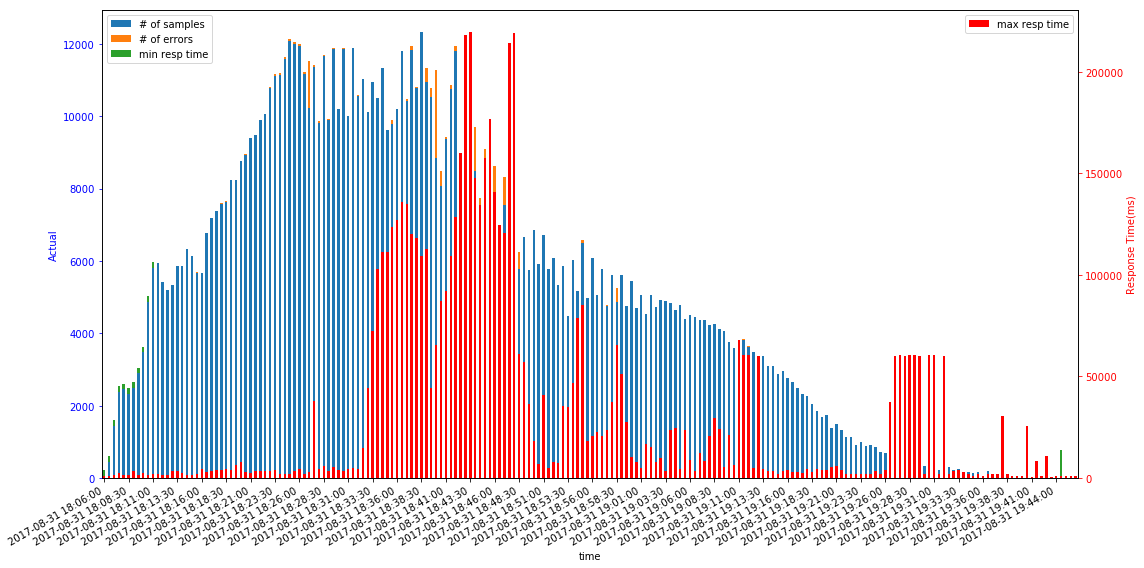

In [266]:
# set the subplots
fig, actual = plt.subplots()

# share the x-axis of 'actual' with 'resptime'
resptime = actual.twinx()

# plot the data from the "detailErrorReport" dataframe using their respective axes
leftplot = detailErrorReport[["# of samples","# of errors","min resp time"]].plot.bar(ax=actual, stacked=True, zorder=5)
rightplot = detailErrorReport["max resp time"].plot.bar(ax=resptime, stacked=True,color="red", zorder=10)

# call our functions
tck = setTicksX(actual)
tcklbl = setTickLabelsX(actual)

# set up our labels and set our ticks and ticklabels based off of our lists that were created by our functions
actual.set_ylabel("Actual", color="b")
actual.tick_params("y", colors="b")
actual.xaxis.set_ticks(tck[::5])
actual.xaxis.set_ticklabels(tcklbl[::5]) 
resptime.set_ylabel("Response Time(ms)", color="r")
resptime.tick_params("y", colors="r")
resptime.xaxis.set_ticks(tck[::5])
resptime.xaxis.set_ticklabels(tcklbl[::5])

# auto format - adds slant to the x-axis ticklabels
fig.autofmt_xdate()

# add legend for 'leftplot' on left side of graph 
actual.legend(loc=2)

# create and add legend for 'rightplot' on right side of graph
handles, labels = rightplot.get_legend_handles_labels()
rightplot.legend(handles, labels, loc=1)

# plt.figlegend(handles="fd",labels=("ld", "ld","dsfds"))
# plt.legend(handles=[leftplot, rightplot], labels=("# of samples","# of errors","min resp time","max resp time"),loc="upper right")

# show our graph
fig.tight_layout()
plt.show()

### Now our line graphs
For the three line graphs, we'll simply:
1. Plot our dataframe data
2. Set the x-axis ticks with the Period range that we built
3. And, display the graph!

#### Threads Graph

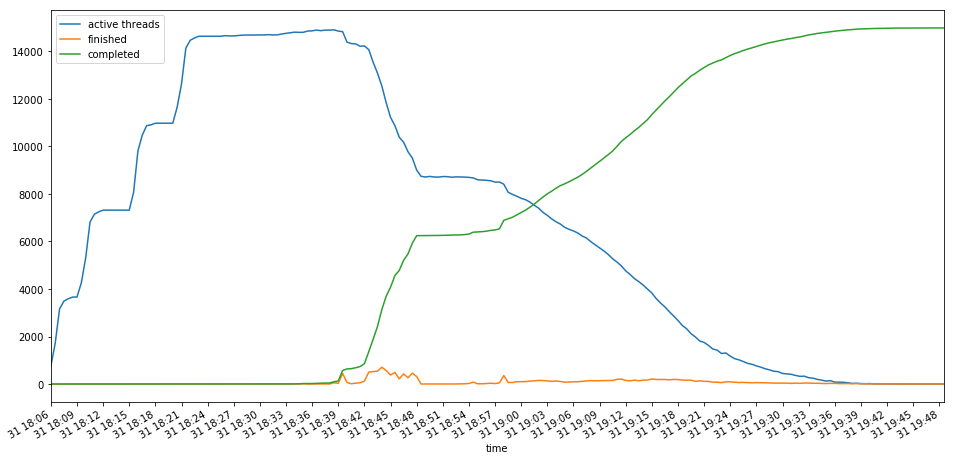

In [243]:
detailErrorReport[["active threads", "finished", "completed"]].plot()

plt.xticks(idx.to_timestamp())

plt.show()

#### Errors Graph

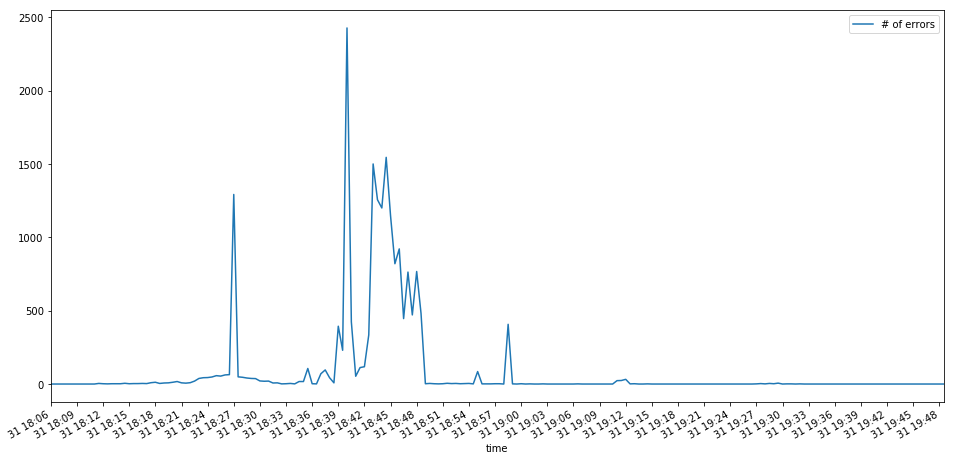

In [263]:
errgraph = detailErrorReport['# of errors'].plot()

plt.xticks(idx.to_timestamp())

handles, labels = errgraph.get_legend_handles_labels()
errgraph.legend(handles, labels, loc=1)

plt.show()

#### Response Time Graph
The response time graph will have 2 y-axes sharing an x-axis.
<br>
We'll use the same workflow as the bar graph.
1. Plot data from dataFrame: **min** and **max response times**
2. Set the y Labels
3. set x-axis ticks as our Period range: **idx**
4. Display!

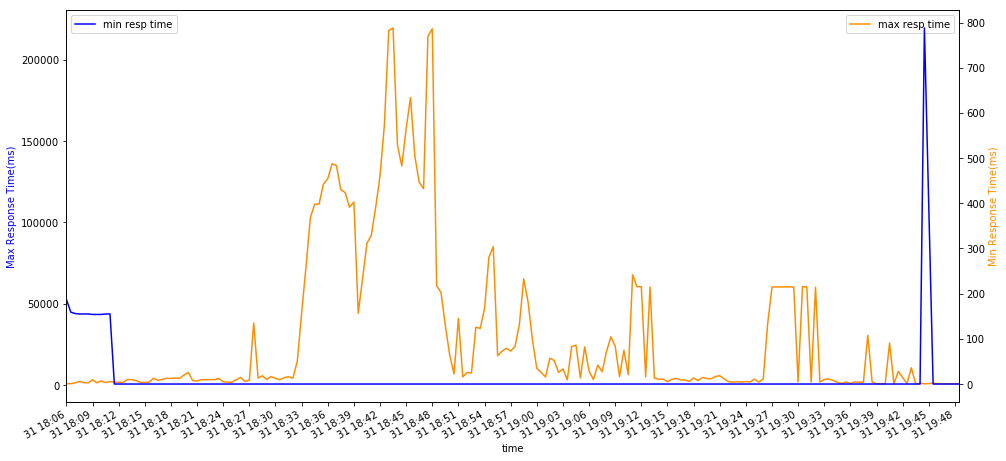

In [234]:
fig2, maxres = plt.subplots()

minres = plt.twinx()

detailErrorReport[['max resp time']].plot(ax=maxres, c='darkorange')
detailErrorReport[['min resp time']].plot(ax=minres, c="blue")

minres.set_ylabel("Min Response Time(ms)", color="darkorange")
maxres.set_ylabel("Max Response Time(ms)", color="blue")

plt.xticks(idx.to_timestamp())

plt.show()

## resources:
Handy [pandas snippets](https://gist.github.com/bsweger/e5817488d161f37dcbd2)